Riding the Wave

Numerical schemes for hyperbolic PDEs

Red Light!

Let's explore behavior for a moving shock wave. Imagine a busy road and a red light at x=4. Cars accumulate quickly in the front where max allowed density of cars between x=3 and x=4. Incoming traffic is 50% of the max allowed density.

mathematically we have:

\begin{equation}\rho(x,0) = \left\{ \begin{array}{cc}
0.5 \rho_{\rm max} & 0 \leq x < 3  \\
\rho_{\rm max} & 3 \leq x \leq 4 \\ \end{array} \right.\end{equation}

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [24]:
def rho_red_light(nx, rho_max, rho_in):
    """Computes "red light" initial condition with shock

    Parameters
    ----------
    nx        : int
        Number of grid points in x
    rho_max   : float
        Maximum allowed car density
    rho_in    : float
        Density of incoming cars 

    Returns
    -------
    rho: array of floats
        Array with initial values of density
    """
    rho = rho_max*numpy.ones(nx)
    rho[:(nx-1)*3./4.] = rho_in
    return rho

In [25]:
#Basic initial condition parameters
#defining grid size, time steps, CFL condition, etc...
nx = 81
nt = 30
dx = 4.0/(nx-1)

rho_in = 5.
rho_max = 10.

u_max = 1.

x = numpy.linspace(0,4,nx)

rho = rho_red_light(nx, rho_max, rho_in)

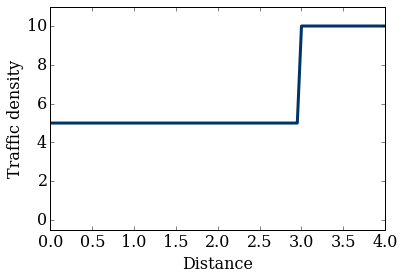

In [26]:
pyplot.plot(x, rho, color='#003366', ls='-', lw=3)
pyplot.ylabel('Traffic density')
pyplot.xlabel('Distance')
pyplot.ylim(-0.5,11.);

The question to solve is how will cars accumulate at the red light?

We will solve using the following shemes:
-Lax-Friedrichs
-Lax-Wendroff
-MacCormack

The wave speed $u_{wave}$ is $ -1 $ for $ \rho = \rho_{max}/2$ making all velocities negative. We should see solution moving left

In [27]:
def computeF(u_max, rho_max, rho):
    """Computes flux F=V*rho

    Parameters
    ----------
    u_max  : float
        Maximum allowed velocity
    rho    : array of floats
        Array with density of cars at every point x
    rho_max: float
        Maximum allowed car density
        
    Returns
    -------
    F : array
        Array with flux at every point x
    """
    return u_max*rho*(1-rho/rho_max)

In [28]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

In [34]:
def animate(data):
    x = numpy.linspace(0,4,nx)
    y = data
    line.set_data(x,y)
    return line,

Lax-Friedrichs Scheme

Conservation Law for vehicle traffic

$$\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0$$

F is the traffic flux 

$$F = \rho u_{max} \left(1-\frac{\rho}{\rho_{max}} \right)$$

In the time variable the natural choice is always forward difference:

$$\frac{\partial \rho}{\partial t} = \frac{1}{\Delta t}(\rho_i^{n+1} - \rho_i^n)$$

In order to get second-order accuracy in space use a central difference

$$\frac{\partial F}{\partial x} = \frac{1}{2\Delta x}(F_{i+1} - F_{i-1})$$

BUT the forward time central space discretization is unstable! The Lax Friedrichs scheme is to replace the solution at $\rho_i^n$ by the average of the values at the neighboring grid points.

$$\frac{\rho_i^{n+1} -\frac{1}{2}(\rho_{i+1}^n + \rho_{i-1}^n)}{\Delta t} = \frac{F_{i+1}^n - F_{i-1}^n}{2 \Delta x}$$

To implement the scheme in the code we need to isolate the next step:

$$\rho_i^{n+1} = \frac{1}{2}(\rho_{i+1}^n + \rho_{i-1}^n) - \frac{\Delta t}{2\Delta x}(F_{i+1}^n - F_{i-1}^n)$$



In [39]:
def laxfriedrichs(rho, nt, dt, dx, rho_max, u_max):
    """ Computes the solution with Lax-Friedrichs scheme
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    u_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))      
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()              
    
    '''
    Now, for each timestep, we're going to calculate rho^n+1, 
    then set the value of rho equal to rho^n+1 so we can calculate 
    the next iteration.  For every timestep, the entire vector
    rho^n is saved in a single row of our results array rho_n.
    '''
    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        rho_n[t,1:-1] = .5*(rho[2:]+rho[:-2]) - dt/(2*dx)*(F[2:]-F[:-2])
        rho_n[t,0] = rho[0] # boundary condition at x=0
        rho_n[t,-1] = rho[-1] # boundary condition at x=4
        rho = rho_n[t].copy()
        
    return rho_n

In [40]:
sigma = 1.0
dt = sigma*dx/u_max

rho = rho_red_light(nx, rho_max, rho_in)      #make sure that u is set to our expected initial conditions
rho_n = laxfriedrichs(rho, nt, dt, dx, rho_max, u_max)

In [43]:
rho_n.shape

(30, 81)

TypeError: set() takes 1 positional argument but 3 were given

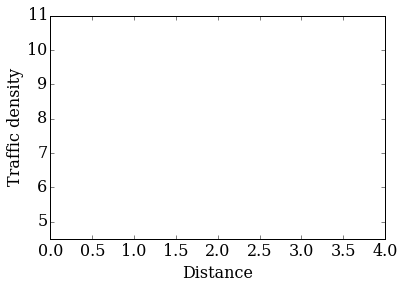

In [44]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

Think



In [12]:
#CFL = 0.5

sigma = 0.5
dt = sigma*dx/u_max

rho = rho_red_light(nx,rho_max, rho_in)
rho_n = laxfriedrichs(rho, nt, dt, dx,rho_max,u_max)



In [13]:
anim = animation.FuncAnimation(fig,animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

TypeError: set() takes 1 positional argument but 3 were given

Dig Deeper



Lax-Wendroff Scheme

Derivation:

Taylor Expansion:

$$\rho^{n+1} = \rho^n + \frac{\partial \rho^n}{\partial t} \Delta t + \frac{(\Delta t)^2}{2} \frac{\partial^2 \rho^n}{\partial t^2} + ...$$

Chain Rule:

$$\frac{\partial \rho}{\partial t} = - \frac{\partial F}{\partial x} = - \frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial x} = - J\frac{\partial \rho}{\partial x}$$

Where

$$ J = \frac{\partial F}{\partial \rho} = u_{max} \left( 1-2 \frac{\rho}{\rho_{max}} \right)$$

is the jacobian for the traffic model.

$$\frac{\partial F}{\partial t} = \frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial t} = J\frac{\partial \rho}{\partial t} = -J\frac{\partial F}{\partial x}$$

Implied:

$$\frac{\partial^2 \rho}{\partial t^2} = \frac{\partial}{\partial x} \left( J \frac{\partial F}{\partial x} \right) $$

$$ \rho^{n+1} = \rho^n - \frac{\partial F^n}{\partial x} \Delta t + \frac{(\Delta t)^2}{2} \frac{\partial}{\partial x} \left( J \frac{\partial F^n}{\partial x} \right) + ...$$

Reorganize this and discretize the spatial with central differenmce:

$$\frac{\rho_i^{n+1} - \rho_i^n}{\Delta t} = - \frac{F_{i+1}^n - F_{i-1}^n}{2 \Delta x} + \frac{\Delta t}{2} \left( \frac{(J\frac{\partial F}{\partial x})_{i+\frac{1}{2}}^n - (J\frac{\partial F}{\partial x})_{i-\frac{1}{2}}^n}{\Delta x} \right) $$

Now approximate the right-most term by using averages:

$$\frac{J_{i+\frac{1}{2}}^n \left( \frac{F_{i+1}^n -F_i^n }{\Delta x} \right) - J_{i-\frac{1}{2}}^n \left( \frac{F_i^n -F_{i-1}^n} {\Delta x} \right)}{\Delta x}$$

Then evaluate the Jacobian at the midpoints:

$$\frac{\frac{1}{2 \Delta x} (J_{i+1}^n + J_i^n)(F_{i+1}^n - F_i^n) - \frac{1}{2 \Delta x} (J_i^n + J_{i-1}^n)(F_{i}^n - F_{i-1}^n) }{\Delta x}$$

Our equation now reads:

$$\frac{\rho_i^{n+1} - \rho_i^n}{\Delta t} = - \frac{F_{i+1}^n - F_{i-1}^n}{2\Delta x} + ... \\
+ \frac{\Delta t}{4 \Delta x^2}((J_{i+1}^n + J_i^n)(F_{i+1}^n - F_i^n) - (J_{i}^n + J_{i-1}^n)(F_{i}^n + F_{i-1}^n))$$

Solving for $\rho_i^{n+1}$

$$\rho_i^{n+1} = \rho_i^{n} - \frac{\Delta t}{2 \Delta x}(F_{i+1}^n + F_{i-1}^n)+... \\
+ \frac{(\Delta t)^2}{4 (\Delta x)^2}((J_{i+1}^n + J_i^n)(F_{i+1}^n - F_i^n) - (J_{i}^n + J_{i-1}^n)(F_{i}^n + F_{i-1}^n))$$


In [48]:
def Jacobian(u_max, rho_max, rho):
    return u_max*(1-2*rho/rho_max)

def laxwendroff(rho, nt, dt, dx, rho_max, u_max):
    rho_n = numpy.zeros((nt,len(rho)))
    rho_n[:,:]=rho.copy()
    
    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        J = Jacobian(u_max, rho_max, rho)        
        
        rho_n[t,1:-1] = rho[1:-1]-dt/(2*dx)*(F[2:]-F[:-2]) + dt**2/(4*dx**2) * ( (J[2:]+J[1:-1])*(F[2:]-F[1:-1]) - (J[1:-1]+J[:-2])*(F[1:-1]-F[:-2]) )
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho=rho_n[t].copy()
                                                
    return rho_n

In [49]:
rho = rho_red_light(nx, rho_max, rho_in)
sigma = 1
dt = sigma*dx/u_max
rho_n = laxwendroff(rho, nt,dt,dx,rho_max, u_max)

TypeError: set() takes 1 positional argument but 3 were given

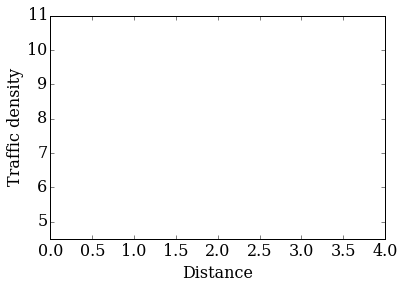

In [50]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

TypeError: set() takes 1 positional argument but 3 were given

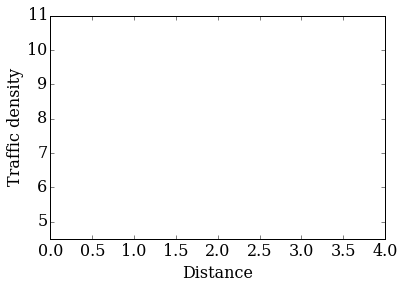

In [51]:
rho = rho_red_light(nx, rho_max, rho_in)
sigma = 0.5
dt = sigma*dx/u_max
rho_n = laxwendroff(rho, nt,dt,dx,rho_max, u_max)

fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

MacCormack Scheme


$$\rho_i^* = \rho_i^n - \frac{\Delta t}{\Delta x} (F_{i+1}^n - F_i^n)   (predictor)$$ 

$$\rho_i^* = \frac{1}{2}(\rho_i^n + \rho_i^* - \frac{\Delta t}{\Delta x} (F_{i}^* - F_{i-1}^*))   (corrector)$$ 


In [52]:
def maccormack(rho,nt,dt,dx,u_max,rho_max):
    rho_n = numpy.zeros((nt,len(rho)))
    rho_star = numpy.empty_like(rho)
    rho_n[:,:] = rho.copy()
    rho_star = rho.copy()
    
    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        rho_star[:-1] = rho[:-1] - dt/dx * (F[1:]-F[:-1])
        Fstar = computeF(u_max, rho_max, rho_star)
        rho_n[t,1:] = .5*(rho[1:]+rho_star[1:] - dt/dx * (Fstar[1:] - Fstar[:-1]))
        rho = rho_n[t].copy()
        
    return rho_n

TypeError: set() takes 1 positional argument but 3 were given

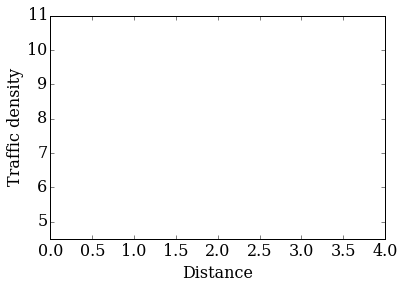

In [53]:
rho = rho_red_light(nx, rho_max, rho_in)
sigma = 1.0
dt = sigma*dx/u_max
rho_n = maccormack(rho, nt,dt,dx,u_max, rho_max)

fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

TypeError: set() takes 1 positional argument but 3 were given

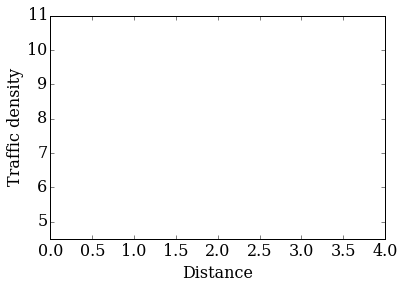

In [54]:
rho = rho_red_light(nx, rho_max, rho_in)
sigma = 0.5
dt = sigma*dx/u_max
rho_n = maccormack(rho, nt,dt,dx,u_max, rho_max)

fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')